In [1]:
# 資料處理相關模組
import numpy as np
import pandas as pd
from collections import Counter
import random
from sklearn.model_selection import train_test_split, KFold, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

# PyTorch 深度學習模組
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader, SubsetRandomSampler, Subset

# 影像處理相關模組
import torchvision
import torchvision.models as models
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

# 檔案路徑處理相關
import os
from pathlib import Path

In [2]:
# GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('GPU State:', device)

GPU State: cuda:0


In [3]:
# Hyperparameter
NUM_EPOCHS = 100
BATCH_SIZE = 64
LR = 0.001

In [4]:
train_dir = "trainset"
test_dir = "testset"
print(train_dir)
print(test_dir)

trainset
testset


In [5]:
TRANSFORM_IMG = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

### Load all the data

In [6]:
train_data = torchvision.datasets.ImageFolder(root=train_dir, transform=TRANSFORM_IMG)
train_data_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=3)

# Data for visualization
vis_data_loader = data.DataLoader(train_data, batch_size=8, shuffle=True, num_workers=3)

### Information of dataset

In [7]:
im = Image.open(train_data.imgs[2][0])
print(im.mode)
img_array = np.array(im)
print(img_array.shape)

RGB
(25, 27, 3)


['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch']
[0, 1, 2, 3, 4, 5, 6, 7]
('trainset\\Center\\0.jpg', 0)
{0: 3462, 1: 409, 2: 2417, 3: 8554, 4: 1620, 5: 54, 6: 609, 7: 500}


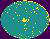

In [ ]:
print(train_data.classes)
print(list(train_data.class_to_idx.values()))
print(train_data.imgs[0])
print(dict(Counter(train_data.targets)))

im = Image.open(train_data.imgs[0][0])
display(im)

### 資料不平衡處理

In [9]:
# 隨機刪除 Edge-Loc 中17%的圖片
edge_ring_dir = Path('trainset/Edge-Loc')
images = list(edge_ring_dir.glob('*.jpg'))
num_to_delete = int(len(images) * 0.17)
images_to_delete = random.sample(images, num_to_delete)

for image_path in images_to_delete:
    os.remove(image_path)

In [10]:
# 隨機刪除 Edge-Ring 中75%的圖片
edge_ring_dir = Path('trainset/Edge-Ring')
images = list(edge_ring_dir.glob('*.jpg'))
num_to_delete = int(len(images) * 0.75)
images_to_delete = random.sample(images, num_to_delete)

for image_path in images_to_delete:
    os.remove(image_path)

In [11]:
# 隨機刪除 Center 中42%的圖片
edge_ring_dir = Path('trainset/Center')
images = list(edge_ring_dir.glob('*.jpg'))
num_to_delete = int(len(images) * 0.42)
images_to_delete = random.sample(images, num_to_delete)

for image_path in images_to_delete:
    os.remove(image_path)

In [12]:
augmentation_tasks = {
    'Donut': 1500,
    'Loc':400,
    'Near-full': 2000,
    'Random': 1400,
    'Scratch': 1500
}

# augmentation 設定
augmentation_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomApply([transforms.RandomRotation(45, fill=(0))], p=0.8),  # 旋轉
    transforms.RandomApply([transforms.RandomRotation(17, fill=(0))], p=0.7),  # 旋轉
    transforms.RandomHorizontalFlip(p=0.7),  # 水平翻轉
    transforms.RandomVerticalFlip(p=0.7),  # 垂直翻轉
    transforms.RandomApply([transforms.RandomRotation(62, fill=(0))], p=0.6),  # 旋轉
])

# 定義augmentation函式
def augment_images(category, num_augmentations):
    # 指定資料夾路徑
    category_dir = Path(f'trainset/{category}')
    images = list(category_dir.glob('*.jpg'))  # 假設圖片格式為 .jpg

    for i in range(num_augmentations):
        # 隨機選取圖片並打開
        img_path = random.choice(images)
        img = Image.open(img_path)

        # 應用增強
        augmented_img = augmentation_transform(img)

        # 保存增強後的圖片
        augmented_img.save(category_dir / f"augmented_{i}.jpg")

    print(f"{category} 類別的 {num_augmentations} 張增強圖片已生成並存入資料夾中。")

# 執行每個類別的augmentation
for category, num_augmentations in augmentation_tasks.items():
    augment_images(category, num_augmentations)


Donut 類別的 1500 張增強圖片已生成並存入資料夾中。
Loc 類別的 400 張增強圖片已生成並存入資料夾中。
Near-full 類別的 2000 張增強圖片已生成並存入資料夾中。
Random 類別的 1400 張增強圖片已生成並存入資料夾中。
Scratch 類別的 1500 張增強圖片已生成並存入資料夾中。


In [43]:
'''
# SMOTE
# Define augmentation tasks
augmentation_num = 1000
smote_category = ['Donut', 'Loc', 'Near-full', 'Random', 'Scratch']

# Load images and labels into numpy arrays
def load_images_from_directory(directory):
    category_image_paths = {}  # Dictionary to store image paths by category
    for category in smote_category:
        category_dir = Path(directory) / category
        image_paths = list(category_dir.glob('*.jpg'))
        category_image_paths[category] = image_paths
    return category_image_paths

# Load image paths
category_image_paths = load_images_from_directory('trainset')

# Randomly select and process images
def select_and_process_images(category_image_paths):
    images = []
    labels = []
    
    for category in smote_category:
        all_paths = category_image_paths.get(category, [])
        selected_paths = random.choices(all_paths, k=augmentation_num)
      
        for img_path in selected_paths:
            img = Image.open(img_path).resize((64, 64))  # 保持 RGB 格式
            images.append(np.array(img).flatten())  # 將 RGB 圖片平展為向量
            labels.append(category)
    
    return np.array(images), np.array(labels)

# Process images and labels
images, labels = select_and_process_images(category_image_paths)

# Apply SMOTE for data augmentation
smote = SMOTE(random_state=42,k_neighbors=3)
X_smote, y_smote = smote.fit_resample(images, labels)

# Convert augmented data back to images and save them
def save_smote_generated_images(X_augmented, y_augmented):
    for i, (image_vector, label) in enumerate(zip(X_augmented, y_augmented)):
        # Reshape the vector back to an RGB image
        img_array = image_vector.reshape(64, 64, 3).astype(np.uint8)
        img = Image.fromarray(img_array, 'RGB')

        # Save the image
        category_dir = Path('trainset') / label
        category_dir.mkdir(parents=True, exist_ok=True)
        img.save(category_dir / f"smote_generated_{i}.jpg")

# Save the images
save_smote_generated_images(X_smote, y_smote)
print("SMOTE-generated images have been saved successfully.")
'''

'\n# SMOTE\n# Define augmentation tasks\naugmentation_num = 1000\nsmote_category = [\'Donut\', \'Loc\', \'Near-full\', \'Random\', \'Scratch\']\n\n# Load images and labels into numpy arrays\ndef load_images_from_directory(directory):\n    category_image_paths = {}  # Dictionary to store image paths by category\n    for category in smote_category:\n        category_dir = Path(directory) / category\n        image_paths = list(category_dir.glob(\'*.jpg\'))\n        category_image_paths[category] = image_paths\n    return category_image_paths\n\n# Load image paths\ncategory_image_paths = load_images_from_directory(\'trainset\')\n\n# Randomly select and process images\ndef select_and_process_images(category_image_paths):\n    images = []\n    labels = []\n    \n    for category in smote_category:\n        all_paths = category_image_paths.get(category, [])\n        selected_paths = random.choices(all_paths, k=augmentation_num)\n      \n        for img_path in selected_paths:\n            img

In [44]:
'''
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, std=1.0):
        self.mean = mean
        self.std = std

    def __call__(self, img):
        if not isinstance(img, np.ndarray):
            img = np.array(img)  # 將圖像轉換為 NumPy 陣列
        
        noise = np.random.normal(self.mean, self.std, img.shape)
        noisy_img = img + noise
        noisy_img = np.clip(noisy_img, 0, 255)  # 確保像素值在 [0, 255] 範圍內
        return Image.fromarray(noisy_img.astype(np.uint8))  # 將陣列轉換回 PIL 圖像
'''

'\nclass AddGaussianNoise(object):\n    def __init__(self, mean=0.0, std=1.0):\n        self.mean = mean\n        self.std = std\n\n    def __call__(self, img):\n        if not isinstance(img, np.ndarray):\n            img = np.array(img)  # 將圖像轉換為 NumPy 陣列\n        \n        noise = np.random.normal(self.mean, self.std, img.shape)\n        noisy_img = img + noise\n        noisy_img = np.clip(noisy_img, 0, 255)  # 確保像素值在 [0, 255] 範圍內\n        return Image.fromarray(noisy_img.astype(np.uint8))  # 將陣列轉換回 PIL 圖像\n'

### 重新讀取圖片

In [13]:
TRANSFORM_IMG = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.347, 0.5225, 0.3851], std=[0.2355, 0.2780, 0.1610]),
    transforms.Normalize((0.5,),(0.5))
])

In [14]:
train_data = torchvision.datasets.ImageFolder(root=train_dir, transform=TRANSFORM_IMG)
train_data_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=3)

# Data for visualization
vis_data_loader = data.DataLoader(train_data, batch_size=8, shuffle=True, num_workers=3)

In [15]:
# 劃分訓練集和驗證集
train_size = int(0.9 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_data, [train_size, val_size])

# 建立訓練和驗證資料加載器
train_data_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=3)
val_data_loader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=3)

In [16]:
# im = Image.open(train_data.imgs[0][0])
# img_array = np.array(im)
print(train_data.classes)
print(list(train_data.class_to_idx.values()))
print(train_data.imgs[0])
print(dict(Counter(train_data.targets)))
len(train_data_loader) #批次數量

['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full', 'Random', 'Scratch']
[0, 1, 2, 3, 4, 5, 6, 7]
('trainset\\Center\\0.jpg', 0)
{0: 2008, 1: 1909, 2: 2007, 3: 2139, 4: 2020, 5: 2054, 6: 2009, 7: 2000}


228

### Define the VGG architecture

In [17]:
class VGGNet(nn.Module):
    def __init__(self):
        super(VGGNet, self).__init__()

        self.cnn = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 16, 3, padding=1),  # [16, 128, 128]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),  # [16, 128, 128]
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # [16, 64, 64]

            # Block 2
            nn.Conv2d(16, 32, 3, padding=1),  # [32, 64, 64]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),  # [32, 64, 64]
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # [32, 32, 32]

            # Block 3
            nn.Conv2d(32, 64, 3, padding=1),  # [64, 32, 32]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),  # [64, 32, 32]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # [64, 16, 16]

            # Block 4
            nn.Conv2d(64, 128, 3, padding=1),  # [128, 16, 16]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),  # [128, 16, 16]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # [128, 8, 8]

            # Additional Block for 128x128 input
            nn.Conv2d(128, 256, 3, padding=1),  # [256, 8, 8]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),  # [256, 8, 8]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # [256, 4, 4]
        )

        self.fc = nn.Sequential(
            nn.Linear(256 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),  # 50% dropout
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 8)  # Output layer for 8 classes
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Move to device (e.g., GPU)
net = VGGNet().to(device)


In [18]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Compute cross entropy loss
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        
        # Compute the modulating factor (1 - p_t) ^ gamma
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [19]:
# Define loss function
criterion = FocalLoss(alpha=1, gamma=2)
# criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.00005, weight_decay=1e-5)
#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

Epoch: 1/100, Loss: 0.7865
Epoch: 1/100, Validation Loss: 0.4060, Validation Accuracy: 0.7622
Epoch: 2/100, Loss: 0.3157
Epoch: 2/100, Validation Loss: 0.2536, Validation Accuracy: 0.8260
Epoch: 3/100, Loss: 0.2187
Epoch: 3/100, Validation Loss: 0.1996, Validation Accuracy: 0.8458
Epoch: 4/100, Loss: 0.1621
Epoch: 4/100, Validation Loss: 0.1530, Validation Accuracy: 0.8830
Epoch: 5/100, Loss: 0.1330
Epoch: 5/100, Validation Loss: 0.1605, Validation Accuracy: 0.8799
Epoch: 6/100, Loss: 0.1009
Epoch: 6/100, Validation Loss: 0.0953, Validation Accuracy: 0.9201
Epoch: 7/100, Loss: 0.0853
Epoch: 7/100, Validation Loss: 0.0995, Validation Accuracy: 0.9263
Epoch: 8/100, Loss: 0.0676
Epoch: 8/100, Validation Loss: 0.1010, Validation Accuracy: 0.9276
Epoch: 9/100, Loss: 0.0547
Epoch: 9/100, Validation Loss: 0.0700, Validation Accuracy: 0.9474
Epoch: 10/100, Loss: 0.0485
Epoch: 10/100, Validation Loss: 0.0940, Validation Accuracy: 0.9307
Epoch: 11/100, Loss: 0.0379
Epoch: 11/100, Validation Loss

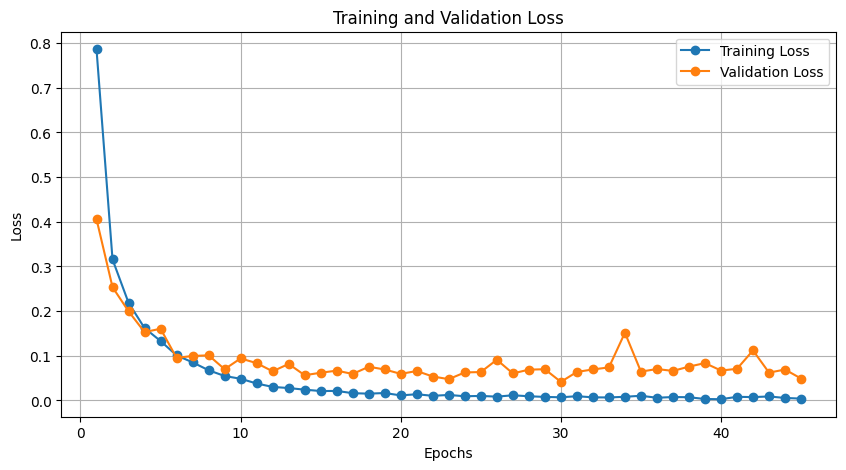

In [20]:
# 初始化變數
best_loss = float('inf')  # Initialize best loss
early_stop = 0
patience = 15
train_losses = []  # 用於記錄每個 epoch 的訓練損失
val_losses = []    # 用於記錄每個 epoch 的驗證損失

for epoch in range(NUM_
                   EPOCHS):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_data_loader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(net.parameters(), max_norm=10)
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

    # 計算每個 epoch 的平均訓練損失
    epoch_train_loss = running_loss / len(train_data_loader)
    train_losses.append(epoch_train_loss)  # 記錄訓練損失
    print(f'Epoch: {epoch + 1}/{NUM_EPOCHS}, Loss: {epoch_train_loss:.4f}')

    # 計算驗證損失和準確度
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for val_data in val_data_loader:
            val_inputs, val_labels = val_data
            val_inputs = val_inputs.to(device)
            val_labels = val_labels.to(device)
            val_outputs = net(val_inputs)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item()

            # 計算準確度
            _, predicted = torch.max(val_outputs, 1)
            total += val_labels.size(0)
            correct += (predicted == val_labels).sum().item()

    # 計算每個 epoch 的平均驗證損失
    epoch_val_loss = val_loss / len(val_data_loader)
    val_losses.append(epoch_val_loss)  # 記錄驗證損失
    val_accuracy = correct / total

    print(f'Epoch: {epoch + 1}/{NUM_EPOCHS}, Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')

    # 儲存最佳模型參數
    if epoch_val_loss < best_loss:
        best_loss = epoch_val_loss
        torch.save(net.state_dict(), 'best_model.pth')  # Save model parameters
        early_stop = 0
    else:
        early_stop += 1

    if early_stop >= patience:
        print("Early stopping triggered")
        break

print('Finished Training')

# 視覺化訓練損失和驗證損失
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
PATH = 'best_model.pth'
model_test = VGGNet()
model_test.load_state_dict(torch.load(PATH))
model_test.to(device)
model_test.eval()

C:\Users\TIFFANY\AppData\Local\Temp\ipykernel_16672\2530533583.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_test.load_state_dict(torch.load(PATH))


VGGNet(
  (cnn): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    

In [22]:
correct = 0
total = 0
res = []

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():

    for i in range(7894):
        # get test images from test dataset
        tpath = os.path.join(test_dir+'/',str(i)+'.jpg')
        fopen = Image.open(tpath)
        image = TRANSFORM_IMG(fopen)
        image = image.unsqueeze(0)
        image = image.to(device)

        outputs = model_test(image)
        _, predicted = torch.max(outputs.data, 1)

        for j in range(len(predicted)):
          res.append(str(train_data.classes[predicted[j]]))
          
print('Predict finished')


Predict finished


In [23]:
df_ans = pd.DataFrame(res , columns=['Category'])
df_ans.to_csv('mySubmission.csv', index_label='ID')

### Some tips for getting better result
- image size (pick the best suitable size to input)
- different CNN architecture
- data augmentation
- reasonable hyperparameter tuning strategy